<a href="https://colab.research.google.com/github/wolframalexa/humanities-data-analysis/blob/main/chap1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Code and descriptions from Karsdorp, Kestemont, and Riddell's Humanities Data Analysis, Chapter 1: Introduction
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/wolframalexa/humanities-data-analysis/main/1-intro/feeding-america.csv", index_col='date')

# %%
df.head()

,book_id,ethnicgroup,recipe_class,region,ingredients
date,,,,,
1922,fofb.xml,mexican,soups,ethnic,chicken;green pepper;rice;salt;water
1922,fofb.xml,mexican,meatfishgame,ethnic,chicken;rice
1922,fofb.xml,mexican,soups,ethnic,allspice;milk
1922,fofb.xml,mexican,fruitvegbeans,ethnic,breadcrumb;cheese;green pepper;pepper;salt;sar...
1922,fofb.xml,mexican,eggscheesedairy,ethnic,butter;egg;green pepper;onion;parsley;pepper;s...


Number of rows: 48032
Recipe classes: ['soups' 'meatfishgame' 'fruitvegbeans' 'eggscheesedairy' 'breadsweets'
 'beverages' 'accompaniments' 'medhealth']
Number of recipes per class:
 breadsweets        14630
meatfishgame       11477
fruitvegbeans       7085
accompaniments      5495
eggscheesedairy     4150
soups               2631
beverages           2031
medhealth            533
Name: recipe_class, dtype: int64


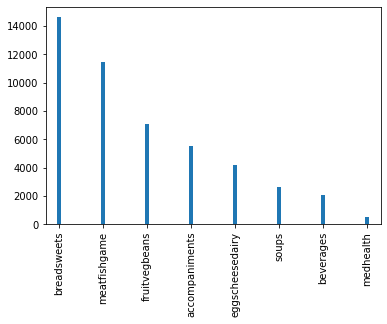

In [6]:
print("Number of rows:", len(df))
print("Recipe classes:", df['recipe_class'].unique())
print("Number of recipes per class:\n", df['recipe_class'].value_counts())

df['recipe_class'].value_counts().plot(kind='bar', color="C0", width=0.1);

Text(0.5, 1.0, 'Recipes by Year of Publication')

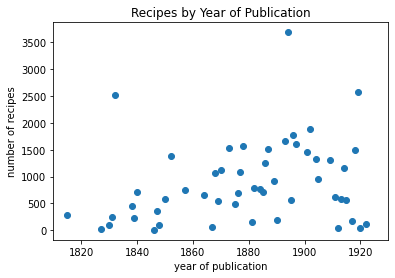

In [8]:
import matplotlib.pyplot as plt

grouped = df.groupby('date')  # group all rows from the same year
recipe_counts = grouped.size()  # compute the size of each group
recipe_counts.plot(style='o', xlim=(1810, 1930))  # plot the group size
plt.ylabel("number of recipes")  # add a label to the y-axis
plt.xlabel("year of publication") # add a label to the x-axis
plt.title("Recipes by Year of Publication")

In [12]:
# split ingredient strings into lists
ingredients = df['ingredients'].str.split(';')
# group all rows from the same year
groups = ingredients.groupby('date')
# merge the lists from the same year
ingredients = groups.sum()
# compute counts per year
ingredients = ingredients.apply(pd.Series.value_counts)
# normalise the counts
ingredients = ingredients.divide(recipe_counts, 0)

ingredients.head()

,butter,salt,water,flour,nutmeg,pepper,sugar,lemon,mace,egg,gravy,egg yolk,white wine,parsley,onion,herb,cream,lemon peel,garlic clove,anchovy,milk,red wine,vinegar,lemon juice,mushroom,bread,oyster,breadcrumb,currant,thyme,sack,bacon,shallot,horseradish,yeast,orange,spice,liver,celery,ginger,...,cream puff paste,squab chicken,crab leg,rock cod,english gooseberry,pine seed,asparagus cream,béarnaise sauce,tea biscuit,indian soy sauce,marron glacé,salmon head,rice stuffing,pumpkin pulp,loganberry juice,fricassee sauce,marsala,newburg sauce,virginia ham,pearl grit,farina cream,parsnip cream,créole sauce,tomato in hot water,chicken okra,colbert sauce,potato cream,california oyster,crayfish butter,french gelatine,pompano fillet,consommé brunoise,strawberry whipped cream,cream puff,perch fillet,avocado,tournedo,rock cod fillet,lime yeast,dried flower
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1803,0.570796,0.435841,0.409292,0.351770,0.272124,0.267699,0.205752,0.205752,0.188053,0.150442,0.143805,0.130531,0.128319,0.128319,0.126106,0.123894,0.123894,0.115044,0.099558,0.086283,0.086283,0.077434,0.077434,0.064159,0.064159,0.059735,0.055310,0.053097,0.050885,0.046460,0.04646,0.044248,0.042035,0.039823,0.037611,0.037611,0.037611,0.035398,0.033186,0.033186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1807,0.357374,0.349839,0.395048,0.219591,0.132400,0.194833,0.274489,0.104413,0.134553,0.177610,0.153929,0.114101,0.032293,0.096878,0.147470,0.072121,0.179763,0.091496,0.072121,0.058127,0.157158,NaN,0.076426,0.029064,0.044133,0.082885,0.034446,0.008611,0.065662,0.023681,NaN,0.047363,NaN,0.001076,0.030140,0.044133,0.030140,0.023681,0.020452,0.026911,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1808,0.531401,0.371981,0.391304,0.352657,0.260870,0.149758,0.396135,0.115942,0.140097,0.294686,0.067633,0.120773,0.048309,0.082126,0.057971,0.062802,0.130435,0.072464,0.038647,0.028986,0.154589,0.019324,0.057971,0.009662,0.024155,0.086957,0.019324,0.004831,0.101449,0.038647,NaN,0.019324,0.009662,0.028986,0.019324,0.038647,0.053140,0.009662,0.009662,0.057971,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1815,0.398551,0.315217,0.322464,0.431159,0.152174,0.083333,0.387681,0.018116,0.036232,0.347826,0.007246,0.021739,NaN,0.007246,0.039855,NaN,0.086957,0.032609,0.039855,NaN,0.289855,NaN,0.050725,0.014493,NaN,0.036232,0.007246,0.003623,0.068841,0.003623,NaN,0.003623,NaN,0.007246,0.115942,0.007246,0.072464,0.007246,0.003623,0.068841,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1827,NaN,0.066667,0.600000,NaN,0.033333,0.033333,0.400000,0.200000,NaN,0.033333,NaN,0.033333,NaN,NaN,NaN,NaN,0.033333,0.033333,0.066667,NaN,0.100000,NaN,0.200000,0.033333,NaN,0.033333,NaN,NaN,0.066667,NaN,NaN,NaN,NaN,0.066667,0.133333,0.033333,NaN,NaN,NaN,0.100000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Recipes with Tomatoes')

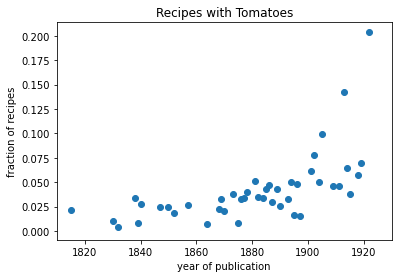

In [13]:

ax = ingredients['tomato'].plot(style='o', xlim=(1810, 1930))
ax.set_ylabel("fraction of recipes")
ax.set_xlabel("year of publication");
plt.title("Recipes with Tomatoes")

Tomatoes were largely considered to be poisonous. They became more popular around 1880 when a new tomato breed was created, transforming it into a commercial crop. This explosion in popularity is apparent in the fraction of recipes that contain tomatoes.

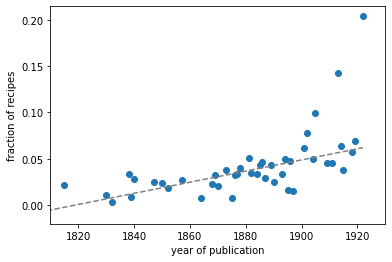

In [14]:
import scipy.stats

def plot_trend(column, df, line_color='grey', xlim=(1810, 1930)):
    slope, intercept, _, _, _ = scipy.stats.linregress(
        df.index, df[column].fillna(0).values)
    ax = df[column].plot(style='o', label=column)
    ax.plot(df.index, intercept + slope * df.index, '--',
             color=line_color, label='_nolegend_')
    ax.set_ylabel("fraction of recipes")
    ax.set_xlabel("year of publication")
    ax.set_xlim(xlim)

plot_trend('tomato', ingredients)

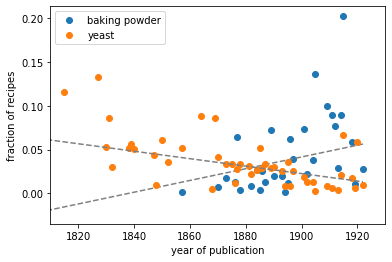

In [15]:
plot_trend('baking powder', ingredients)
plot_trend('yeast', ingredients)
plt.legend();  # add a legend to the plot

As baking powder became more popular, it took market share away from yeast. Baking powder was preferred because it was faster-acting, and the benefits of cooking efficiency are reflected in the trends.

Text(0.5, 1.0, 'Use of Nutmeg')

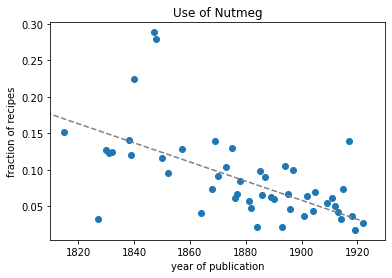

In [17]:
plot_trend('nutmeg', ingredients)
plt.title("Use of Nutmeg")

Nutmeg declined in usage as it fell out of fashion, ceding to other expensive spices.

In [19]:
from sklearn.feature_selection import chi2

# Transform the index into a list of labels, in which each label
# indicates whether a row stems from before or after the Civil War:
labels = ['Pre-Civil War' if year < 1864 else 'Post-Civil War' for year in ingredients.index]
# replace missing values with zero (.fillna(0)),
# and compute the chi2 statistic:
keyness, _ = chi2(ingredients.fillna(0), labels)
# Turn keyness values into a Series, and sort in descending order:
keyness = pd.Series(keyness, index=ingredients.columns).sort_values(ascending=False)

# Top 10 most distinctive elements between pre- and post-war cooking
keyness.head(n=10)

nutmeg           1.072078
rice water       1.057412
loaf sugar       1.057213
mace             0.955977
pearlash         0.759318
lemon peel       0.694849
baking powder    0.608744
soda             0.589730
vanilla          0.533900
gravy            0.453685
dtype: float64

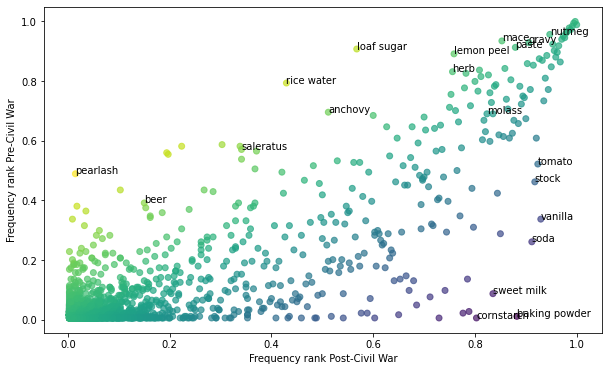

In [20]:
# Visualize popularity before and after Civil War

# step 1: compute summed ingredient counts per year
counts = df['ingredients'].str.split(';').groupby(
    'date').sum().apply(pd.Series.value_counts).fillna(0)

# step 2: construct frequency rankings for pre- and post-war years
pre_cw = counts[counts.index < 1864].sum().rank(method='dense', pct=True)
post_cw = counts[counts.index > 1864].sum().rank(method='dense', pct=True)

# step 3: merge the pre- and post-war data frames
rankings = pd.DataFrame({'Pre-Civil War': pre_cw, 'Post-Civil War': post_cw})

# step 4: produce the plot
fig = plt.figure(figsize=(10, 6))
plt.scatter(rankings['Post-Civil War'], rankings['Pre-Civil War'],
            c=rankings['Pre-Civil War'] - rankings['Post-Civil War'],
            alpha=0.7)

# Add annotations of the 20 most distinctive ingredients
for i, row in rankings.loc[keyness.head(20).index].iterrows():
    plt.annotate(i, xy=(row['Post-Civil War'], row['Pre-Civil War']))

plt.xlabel("Frequency rank Post-Civil War")
plt.ylabel("Frequency rank Pre-Civil War");

In [21]:
# How do cookbooks reflect changing US immigration patterns?

df['ethnicgroup'].value_counts(dropna=False).head(10)

NaN         41432
jewish       3418
creole        939
french        591
oriental      351
italian       302
english       180
german        153
spanish       123
chinese        66
Name: ethnicgroup, dtype: int64

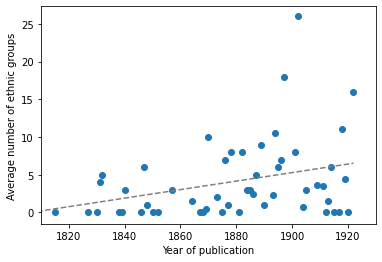

In [22]:
grouped = df.groupby(level='date')
# compute the number of unique ethnic groups per year, divided by the number of books
n_groups = grouped['ethnicgroup'].nunique() / grouped['book_id'].nunique()
n_groups.plot(style='o')

# add a least square line as reference
slope, intercept, _, _, _ = scipy.stats.linregress(
    n_groups.index, n_groups.fillna(0).values)

# create the plot
plt.plot(
    n_groups.index, intercept + slope * n_groups.index, '--', color="grey")
plt.xlim(1810, 1930)
plt.ylabel("Average number of ethnic groups")
plt.xlabel("Year of publication");

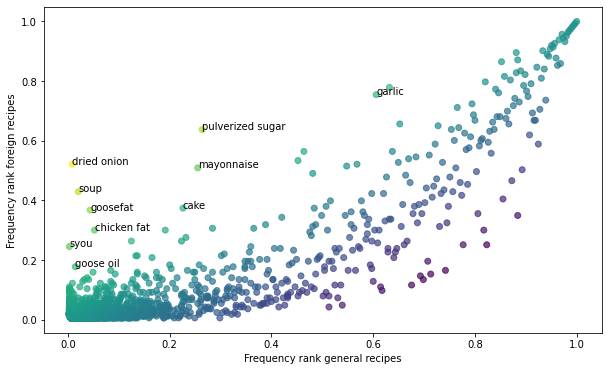

In [118]:
# step 1: add a new column indicating for each recipe whether
#         we have information about its ethnic group
df['foreign'] = df['ethnicgroup'].notnull()

# step 2: construct frequency rankings for foreign and general recipes
counts = df.groupby('foreign')['ingredients'].apply(
    ';'.join).str.split(';').apply(pd.Series.value_counts).fillna(0)

foreign_counts = counts.iloc[1].rank(method='dense', pct=True)
general_counts = counts.iloc[0].rank(method='dense', pct=True)

# step 3: merge the foreign and general data frames
rankings = pd.DataFrame({'foreign': foreign_counts, 'general': general_counts})

# step 4: compute the keyness of ingredients in foreign recipes
#         as the difference in frequency ranks
keyness = (rankings['foreign'] - rankings['general']).sort_values(ascending=False)

# step 5: produce the plot
fig = plt.figure(figsize=(10, 6))
plt.scatter(rankings['general'], rankings['foreign'],
            c=rankings['foreign'] - rankings['general'],
            alpha=0.7)

for i, row in rankings.loc[keyness.head(10).index].iterrows():
    plt.annotate(i, xy=(row['general'], row['foreign']))

plt.xlabel("Frequency rank general recipes")
plt.ylabel("Frequency rank foreign recipes");

This plot shows that certain ingredients are more prevalent in foreign recipes, like dried onion, garlic, and pulverized sugar.


Unique regions: ['ethnic' 'general' 'northeast' 'midwest' 'west' 'south']
Number of recipes per region:
 general      35508
ethnic        7040
midwest       2043
northeast     1320
south         1094
west          1027
Name: region, dtype: int64


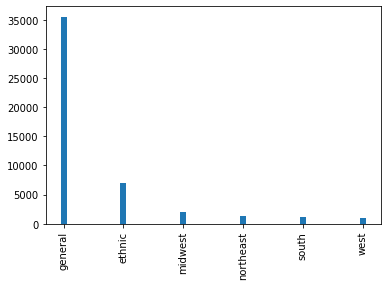

In [31]:
# My code contributions from here on

# Easy
recipes = pd.read_csv("https://raw.githubusercontent.com/wolframalexa/humanities-data-analysis/main/1-intro/feeding-america.csv", index_col='date')
print("Unique regions:", recipes['region'].unique())
print("Number of recipes per region:\n", recipes['region'].value_counts())

recipes['region'].value_counts().plot(kind='bar', color="C0", width=0.1);

There are many more "general" cookbooks than any other kind!

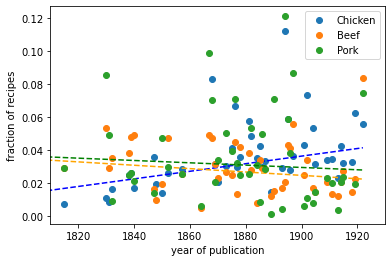

In [36]:
# Medium
# Looking at meat consumption in US cookbooks
plot_trend('chicken', ingredients, line_color='blue')
plot_trend('beef', ingredients, line_color='orange')
plot_trend('pork', ingredients, line_color='green')
plt.legend(['Chicken', 'Beef', 'Pork'])
plt.title("Meat Consumption in American Cookbooks")
# recipes.head(30)

As the number of chicken recipes rises, beef and pork recipes decline slightly. This is not necessarily an analog for consumption; however, it may reflect an increased popularity of chicken.

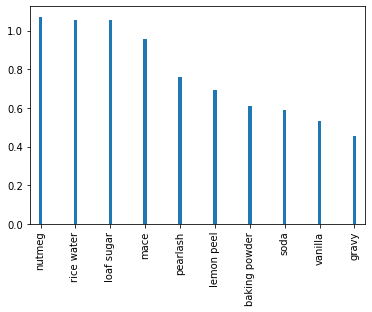

In [40]:
# Most distinctive ingredients for pre and post Civil War Era, using chi^2 keyness measure
keyness, _ = chi2(ingredients.fillna(0), labels)
# Turn keyness values into a Series, and sort in descending order:
keyness = pd.Series(keyness, index=ingredients.columns).sort_values(ascending=False)
keyness.head(10).plot(kind='bar', color="C0", width=0.1);

Text(0, 0.5, 'Number of recipes')

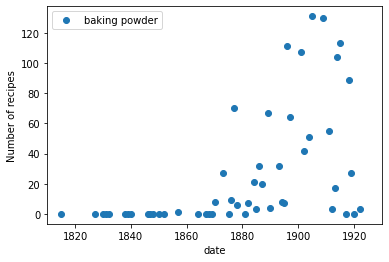

In [116]:
# Number of baking powder recipes by year
counts = recipes['ingredients'].str.split(';').groupby('date').sum().apply(pd.Series.value_counts).fillna(0)
bp = counts['baking powder'].to_frame()
bp.plot(style='o', xlim=(1810, 1930))

plt.ylabel("Number of recipes")


Text(0, 0.5, 'Number of breadsweets recipes')

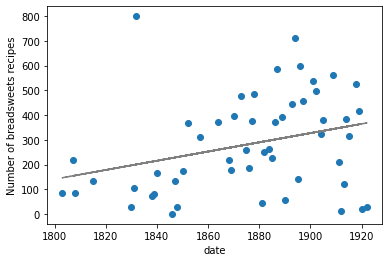

In [113]:
# Number of baked goods recipes by year
types = recipes[recipes['recipe_class'] == 'breadsweets'].value_counts('date').fillna(0)
types.plot(style='o')

# plot trendline
slope, intercept, _, _, _ = scipy.stats.linregress(
    types.index, types.fillna(0).values)
plt.plot(
    types.index, intercept + slope * types.index, '--', color="grey")

plt.ylabel("Number of breadsweets recipes")


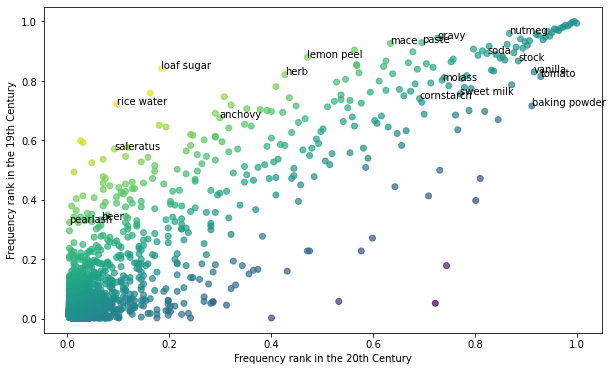

In [117]:
# Challenging

# Visualize popularity in the 19th and 20th centuries

# step 1: compute summed ingredient counts per year
counts = df['ingredients'].str.split(';').groupby(
    'date').sum().apply(pd.Series.value_counts).fillna(0)

# step 2: construct frequency rankings for pre- and post-war years
pre_cent = counts[counts.index < 1900].sum().rank(method='dense', pct=True)
post_cent = counts[counts.index > 1900].sum().rank(method='dense', pct=True)

# step 3: merge the pre- and post-war data frames
rankings = pd.DataFrame({'19th C': pre_cent, '20th C': post_cent})

# step 4: produce the plot
fig = plt.figure(figsize=(10, 6))
plt.scatter(rankings['20th C'], rankings['19th C'],
            c=rankings['19th C'] - rankings['20th C'],
            alpha=0.7)

# Add annotations of the 20 most distinctive ingredients
for i, row in rankings.loc[keyness.head(20).index].iterrows():
    plt.annotate(i, xy=(row['20th C'], row['19th C']))

plt.xlabel("Frequency rank in the 20th Century")
plt.ylabel("Frequency rank in the 19th Century");

Ingredients like pearlash and beer are far more common in the 19th century than in the 20th century, while ingredients like baking powder and tomato become more popular after the turn of the century.

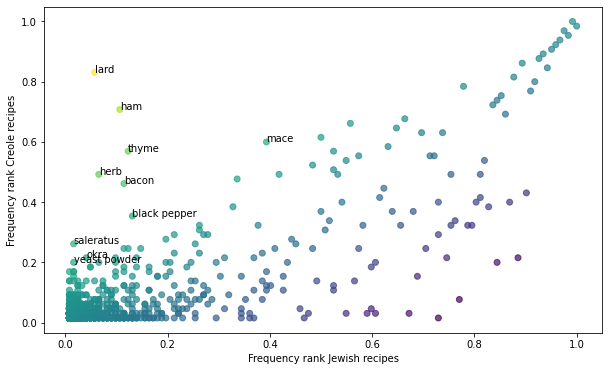

In [129]:
# Compare Jewish and Creole Cuisines

counts = recipes.groupby('ethnicgroup')['ingredients'].apply(
    ';'.join).str.split(';').apply(pd.Series.value_counts).fillna(0)

creole_counts = counts.loc['creole'].rank(method='dense', pct=True)
jewish_counts = counts.loc['jewish'].rank(method='dense', pct=True)

rankings = pd.DataFrame({'creole': creole_counts, 'jewish': jewish_counts})

# compute the keyness of ingredients in creole recipes as the difference in frequency ranks
keyness = (rankings['creole'] - rankings['jewish']).sort_values(ascending=False)

fig = plt.figure(figsize=(10, 6))
plt.scatter(rankings['jewish'], rankings['creole'],
            c=rankings['creole'] - rankings['jewish'],
            alpha=0.7)

for i, row in rankings.loc[keyness.head(10).index].iterrows():
    plt.annotate(i, xy=(row['jewish'], row['creole']))

plt.xlabel("Frequency rank Jewish recipes")
plt.ylabel("Frequency rank Creole recipes");

Ingredients like bacon, lard, and ham are far more common in Creole cuisine than in Jewish cuisine - probably because they aren't kosher.

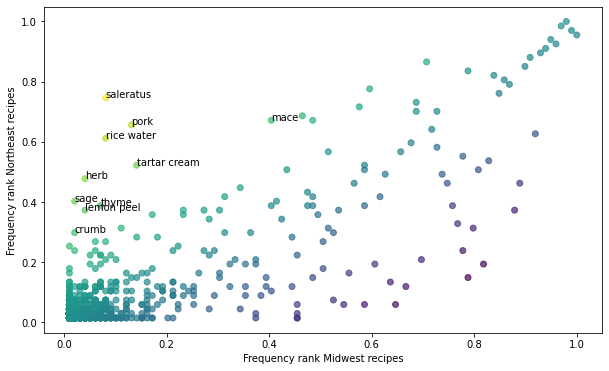

In [138]:
# Compare Jewish and Creole Cuisines

counts = recipes.groupby('region')['ingredients'].apply(
    ';'.join).str.split(';').apply(pd.Series.value_counts).fillna(0)

ne_counts = counts.loc['northeast'].rank(method='dense', pct=True)
mw_counts = counts.loc['midwest'].rank(method='dense', pct=True)

rankings = pd.DataFrame({'northeast': ne_counts, 'midwest': mw_counts})

# compute the keyness of ingredients in northeast recipes as the difference in frequency ranks
keyness = (rankings['northeast'] - rankings['midwest']).sort_values(ascending=False)

fig = plt.figure(figsize=(10, 6))
plt.scatter(rankings['midwest'], rankings['northeast'],
            c=rankings['northeast'] - rankings['midwest'],
            alpha=0.7)

for i, row in rankings.loc[keyness.head(10).index].iterrows():
    plt.annotate(i, xy=(row['midwest'], row['northeast']))

plt.xlabel("Frequency rank Midwest recipes")
plt.ylabel("Frequency rank Northeast recipes");

Ingredients like saleratus, pork, and rice water are far more prevalent in the Northeast than in the Midwest.